In [1]:
import pickle
import pandas as pd
import numpy as np
import functions
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec, Phrases
from gensim.parsing.preprocessing import STOPWORDS as stop_words
from gensim.utils import simple_preprocess
from sklearn.feature_extraction import text
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer

In [2]:
# this is each review cleaned for Doc2Vec. It is df_with_mins with only 'id' and 'text'
cleaned_reviews_df = pd.read_pickle('cleaned_reviews_df.pkl')

# load lookup dictoinary pickle file
file = open('lookup_dict.pickle', 'rb')
lookup_dict = pickle.load(file)
file.close

<function BufferedReader.close>

In [23]:
# uses a customer function to create a list of stopwords
my_stop_words = functions.make_stop_words()

PLEASE NOTE: The next 3 steps can take a suubstantial amount of time

In [ ]:
# initiate a lancaster stemmer, and stem beer reviews while tagging them for Doc2Vec
ls = LancasterStemmer()
tagged_stem_docs = functions.stem_tag_docs(cleaned_reviews_df, my_stop_words)

In [ ]:
# Instantiate a Doc2Vec model, and build the vocab from the tagged documents

model = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=100, workers=8)

model.build_vocab(tagged_stem_docs, progress_per = 100)

In [ ]:
model.train(tagged_stem_docs, total_examples=model.corpus_count, epochs=1)

In [24]:
# this is loading a saved model to skip the above steps
model = Doc2Vec.load('ls-s300-20epoch.model')

In [25]:
vec = model['bourbon']
d2v_test = model.docvecs.most_similar([vec], topn=5000)
functions.location_filter2(d2v_test, lookup_dict, 'WA', 'Seattle', 3)

{20680: ('Fremont Brewing Company', '140119', 'Bourbon Barrel Aged Dark Star'),
 17005: ('Two Beers Brewing Co.', '105241', 'Overhang (Alta Series)'),
 29693: ("Reuben's Brews", '90460', 'Imperial Stout - Bourbon Barrel-Aged')}

In [22]:
model.docvecs.most_similar('55401')

[('140119', 0.5883382558822632),
 ('149554', 0.546276330947876),
 ('100421', 0.5412693023681641),
 ('41815', 0.5305579304695129),
 ('41121', 0.5170774459838867),
 ('80197', 0.5137624144554138),
 ('10672', 0.5092458724975586),
 ('20767', 0.5087647438049316),
 ('34313', 0.5021741390228271),
 ('46230', 0.49639180302619934)]

### Plotting

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
# Load beers and drop one that does not have a style, then display all beer styles
beers = pd.read_csv('beers-breweries-and-beer-reviews/beers.csv')
beers = beers.drop(206943 ,axis=0)
beers['style'].unique()

array(['English Oatmeal Stout', 'Russian Imperial Stout', 'Scottish Ale',
       'American Imperial Stout', 'American Cream Ale',
       'Japanese Rice Lager', 'American Lager', 'American IPA',
       'German Bock', 'English Stout', 'English Bitter',
       'Belgian Witbier', 'American Strong Ale',
       'American Pale Wheat Ale', 'Berliner Weisse',
       'American Pale Ale (APA)', 'British Barleywine',
       'American Black Ale', 'Baltic Porter', 'American Adjunct Lager',
       'European Pale Lager', 'American Porter', 'Fruit and Field Beer',
       'American Imperial IPA', 'American Wild Ale', 'Irish Red Ale',
       'English Pale Ale', 'American Amber / Red Lager', 'Belgian Saison',
       'Belgian IPA', 'Rye Beer', 'Belgian Quadrupel (Quad)',
       'German Hefeweizen', 'American Stout', 'Smoke Beer',
       'Belgian Tripel', 'American Amber / Red Ale', 'Pumpkin Beer',
       'German Maibock', 'German Dunkelweizen', 'Belgian Dark Ale',
       'Vienna Lager', 'English Extra Spec

In [108]:
## Because there are so many styles, I wanted to bucket styles into general categories
beers['style'] = beers['style'].apply(lambda x: 'IPA' if 'IPA' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'Stout' if 'Stout' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'Lager' if 'Lager' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'Porter' if 'Porter' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'Lager' if 'Lager' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'German' if 'German' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'Pale' if 'Pale' in x else x)
beers['style'] = beers['style'].apply(lambda x: 'Barleywine' if 'Barleywine' in x else x)
# beers['style'] = beers['style'].apply(lambda x: 'Belgian' if 'Belgian' in x else x)

In [121]:
beers['style'] = beers['style'].apply(lambda x: 'Barleywine' if 'Wheatwine' in x else x)
# beers['style'] = beers['style'].apply(lambda x: 'Sour' if 'Oud Bruin' in x else x)
# beers['style'] = beers['style'].apply(lambda x: 'Sour' if 'Flanders' in x else x)


In [25]:
beers['id'] = beers['id'].astype(str)

In [26]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]

In [27]:
tsne = TSNE(n_components=2,)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

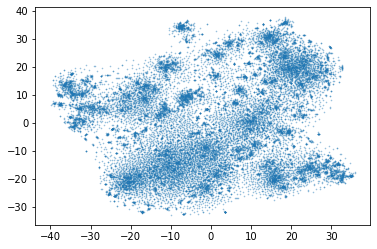

In [28]:
plt.scatter(df['x'], df['y'], s=0.4, alpha=0.4)

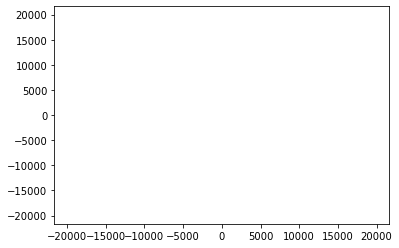

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
for style in beers['style'].unique():
    style_subset = make_tsne_subset(df, beers, style)
    plt.scatter(style_subset['x'],style_subset['y'], s=0.4, alpha=0.4)

In [8]:
dark_styles = ['Stout', 'Porter', 'Barleywine', 'Belgian Quadrupel (Quad)', \
               'Belgian Strong Dark Ale', 'Pumpkin Beer', \
               'Scotch Ale / Wee Heavy']

In [10]:
from functions import make_tsne_subset

In [4]:
df = pd.read_csv('mega_model_tsne_df.csv')

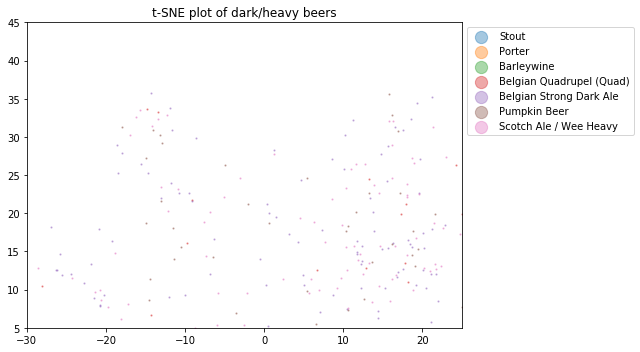

In [12]:
fig = plt.figure(figsize=(9,5))
ax = plt.subplot(111)
ax.set_ylim(bottom=5, top=45)
ax.set_xlim(left=-30, right=25)
for style in dark_styles:
    style_subset = make_tsne_subset(df, beers, style)
    plt.scatter(style_subset['x'],style_subset['y'], s=1.5, alpha=0.4)
ax.legend(dark_styles,\
          bbox_to_anchor =(1,1), markerscale=10)
plt.title('t-SNE plot of dark/heavy beers')
plt.tight_layout()
plt.savefig('dark_beers.png', dpi=200)

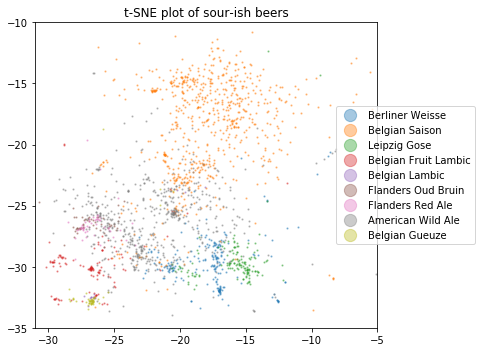

In [210]:
sour_styles = ['Berliner Weisse', 'Belgian Saison', 'Leipzig Gose',\
              'Belgian Fruit Lambic', 'Belgian Lambic', 'Flanders Oud Bruin',\
              'Flanders Red Ale','American Wild Ale', 'Belgian Gueuze']
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.set_ylim(bottom=-35, top=-10)
ax.set_xlim(left=-31, right=-5)
for style in sour_styles:
    style_subset = make_tsne_subset(df, style)
    plt.scatter(style_subset['x'],style_subset['y'], s=1.5, alpha=0.4)
ax.legend(sour_styles,\
          loc=5,bbox_to_anchor =(1.3,0.5), markerscale=10)
plt.title('t-SNE plot of sour-ish beers')
plt.tight_layout()
plt.savefig('sour_beers.png', dpi=200)

In [145]:
beers['style'].unique()

array(['Stout', 'Scottish Ale', 'American Cream Ale', 'Lager', 'IPA',
       'German', 'English Bitter', 'Belgian Witbier',
       'American Strong Ale', 'Pale', 'Berliner Weisse', 'Barleywine',
       'American Black Ale', 'Porter', 'Fruit and Field Beer',
       'American Wild Ale', 'Irish Red Ale', 'Belgian Saison', 'Rye Beer',
       'Belgian Quadrupel (Quad)', 'Smoke Beer', 'Belgian Tripel',
       'American Amber / Red Ale', 'Pumpkin Beer', 'Belgian Dark Ale',
       'English Extra Special / Strong Bitter (ESB)',
       'Scotch Ale / Wee Heavy', 'Leipzig Gose', 'American Brown Ale',
       'American Blonde Ale', 'Bohemian Pilsener',
       'European Export / Dortmunder', 'French Bière de Garde',
       'California Common / Steam Beer', 'Winter Warmer',
       'American Imperial Red Ale', 'Belgian Dubbel', 'Belgian Gueuze',
       'English Brown Ale', 'Belgian Strong Dark Ale',
       'Herb and Spice Beer', 'English Old Ale', 'Chile Beer',
       'American Brett', 'Belgian Fruit L

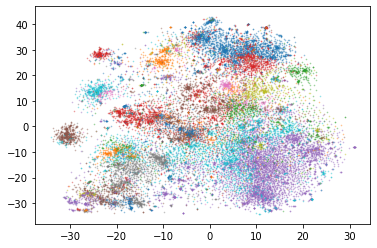

In [135]:
fig = plt.figure()
ax = plt.subplot(111)
for style in beers['style'].unique():
    style_subset = make_tsne_subset(df, style)
    plt.scatter(style_subset['x'],style_subset['y'], s=0.4, alpha=0.4)
# ax.legend(beers['style'].unique(),\
#           bbox_to_anchor =(1,1), markerscale=10)
# ax.set_xlim(left=-5, right=25)
# ax.set_ylim(bottom=15, top=45)

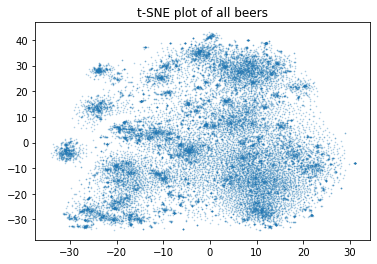

In [209]:
plt.scatter(df['x'], df['y'], s=0.4, alpha=0.3)
plt.title('t-SNE plot of all beers')
# plt.savefig('all_beers.png', dpi=200)

In [83]:
stout = make_tsne_subset(df, 'Stout');

In [82]:
belgian = make_tsne_subset(df, 'Belgian');

In [85]:
porter = make_tsne_subset(df, 'Porter')

In [86]:
pale = make_tsne_subset(df, 'Pale')

In [90]:
lager = make_tsne_subset(df, 'Lager')

In [93]:
wild = make_tsne_subset(df, 'American Wild Ale')

In [122]:
sour = make_tsne_subset(df, 'Sour')

In [24]:
IPAs = beers.loc[beers['style'] == 'IPA']

In [123]:
barleywine = make_tsne_subset(df, 'Barleywine')
winter = make_tsne_subset(df, 'Winter Warmer')

In [34]:
IPAs['id'] = IPAs['id'].astype(str)

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
IPA = set(IPAs['id'])

In [48]:
test = set(df.index).intersection(IPA)

In [52]:
IPA_sub = df[df.index.isin(test)]

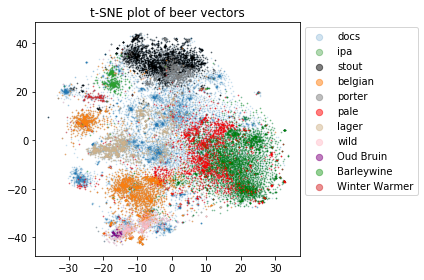

In [146]:
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(df['x'], df['y'], s=0.4, alpha=0.2)
plt.scatter(IPA_sub['x'], IPA_sub['y'], s=0.4, alpha=0.3, c='green')
plt.scatter(stout['x'], stout['y'], s=0.4, alpha=0.5, c='black')
plt.scatter(belgian['x'], belgian['y'], s=0.4, alpha=0.5)
plt.scatter(porter['x'], porter['y'], s=0.4, alpha=0.5, c='gray')
plt.scatter(pale['x'], pale['y'], s=0.4, alpha=0.5, c='red')
plt.scatter(lager['x'], lager['y'], s=0.4, alpha=0.5, c='tan')
plt.scatter(wild['x'], wild['y'], s=0.4, alpha=0.5, c='pink')
plt.scatter(sour['x'], sour['y'], s=0.4, alpha=0.5, c='purple')
plt.scatter(barleywine['x'], barleywine['y'], s=0.4, alpha=0.5)
plt.scatter(winter['x'], winter['y'], s=0.4, alpha=0.5)
# plt.legend(['docs','ipa', 'stout', 'belgian', 'porter', 'pale', 'lager', 'wild'])
ax.legend(['docs','ipa', 'stout', 'belgian', 'porter', 'pale', 'lager', 'wild', 'Oud Bruin', 'Barleywine', 'Winter Warmer'],\
          bbox_to_anchor =(1,1), markerscale=10)
plt.title('t-SNE plot of beer vectors')
plt.tight_layout()
plt.savefig('beerplot.png', dpi=200)


# Testing Models from Thursday Night

In [292]:
get_recs_from_wordvec(stem_model, 'motor', 5000, 'WA', 'Seattle', 4, stem = True)

{403: ('Pyramid Breweries, Inc.', '55540', 'Fling Pale Ale'),
 363: ('Big Time Brewery & Alehouse', '946', 'Prime Time Pale Ale'),
 17005: ('Two Beers Brewing Co.', '197366', 'Wonderland Trail IPA'),
 28192: ('Urban Family Brewing Co.', '144130', 'Hoppy Magnolia')}

In [302]:
get_recs_from_wordvec(stem_model_window, 'citra', 5000, 'WA', 'Seattle', 4, stem = True)

{403: ('Pyramid Breweries, Inc.', '55540', 'Fling Pale Ale'),
 4378: ('Georgetown Brewing Company', '320005', 'Citrus Galaxy'),
 363: ('Big Time Brewery & Alehouse', '946', 'Prime Time Pale Ale'),
 28192: ('Urban Family Brewing Co.', '144130', 'Hoppy Magnolia')}

In [351]:
get_recs_from_wordvec(stem_model2, 'hoppy', 5000, 'WA', 'Seattle', 4, stem = True)

{403: ('Pyramid Breweries, Inc.', '1238', 'Pale Ale'),
 700: ('Elysian Brewing Company', '87540', "Men's Room Black Imperial Ale"),
 17005: ('Two Beers Brewing Co.', '197366', 'Wonderland Trail IPA'),
 363: ('Big Time Brewery & Alehouse', '946', 'Prime Time Pale Ale')}

In [352]:
get_recs_from_wordvec(model, 'dank', 5000, 'WA', 'Seattle', 4, stem = False)

{20680: ('Fremont Brewing Company', '246332', 'Field To Ferment: Simcoe'),
 29693: ("Reuben's Brews", '321482', 'Bits & Bobs'),
 4378: ('Georgetown Brewing Company', '187285', 'Bodhizafa IPA'),
 17005: ('Two Beers Brewing Co.', '197366', 'Wonderland Trail IPA')}

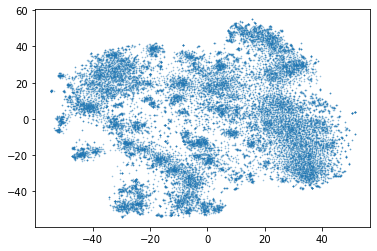

In [296]:
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
plt.scatter(df['x'], df['y'],s=0.4, alpha = 0.4)

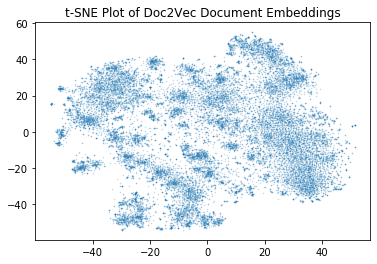

In [320]:
# plt.scatter(stout_df['x'], stout_df['y'], s=0.4, alpha=0.4)
plt.scatter(df['x'], df['y'],s=0.2, alpha = 0.3)
plt.title('t-SNE Plot of Doc2Vec Document Embeddings')
plt.show()

In [10]:
# Yellowbrick
from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

In [11]:
corpus = load_hobbies()

In [13]:
corpus.labels

['gaming', 'cooking', 'cinema', 'books', 'sports']

### Monday February 3rd - Function to search by location, and word or specific beer

In [11]:
model.similar_by_word('ristretto')

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('coffeb', 0.8569510579109192),
 ('charbuck', 0.8553096652030945),
 ('nestlé', 0.8441129922866821),
 ('machiato', 0.8373351097106934),
 ('valrhon', 0.8359583020210266),
 ('espressso', 0.8352636098861694),
 ('caffè', 0.8310182094573975),
 ('esprsso', 0.8310052752494812),
 ('dagob', 0.8305578231811523),
 ('frapuccino', 0.825951337814331)]

In [72]:
vector = model.infer_vector(['tastes', 'like', 'chocolate', 'and', 'thick', 'mouthfeel', 'but', 'hate', 'barrel'])

In [73]:
infer_test = model.docvecs.most_similar([vector], topn=1000)

In [50]:
def location_filter(ranked_beers, state, city, n):

    located_brewery = {}
    # state = 'CA'
    # city = 'Los Angeles'
    counter = 0

    for beer in ranked_beers:
        if counter < n:
            dict_state = lookup_dict[beer[0]]['state']
            dict_city = lookup_dict[beer[0]]['city']
            brewery_id = lookup_dict[beer[0]]['brewery_id']
            brewery_name = lookup_dict[beer[0]]['brewery_name']
            beer_name = lookup_dict[beer[0]]['name']
            if (dict_state == state) and (dict_city == city):
        #             print(beer_breweries_lookup[beer[0]])
#                 print(beer[0])
                if brewery_id in located_brewery:
                    continue
                else:  
                    located_brewery[brewery_id] = (brewery_name, beer[0], beer_name)
                counter += 1
    return located_brewery

def location_filter2(ranked_beers, lookup_dict, state, city, n):
    """ 
    This takes a list of tuples where the 1st element is a beer_id. It searches through the lookup dictionary
    to match breweries based upon their location. And returns n number of recommendations

    It returns the beer_id as key, and brewery_name, beer id, and beer name as values
    """
    located_brewery = {}
    # state = 'CA'
    # city = 'Los Angeles'
    counter = 0

    for beer in ranked_beers:
        if counter < n:
            dict_state = lookup_dict[beer[0]]['state']
            dict_city = lookup_dict[beer[0]]['city']
            brewery_id = lookup_dict[beer[0]]['brewery_id']
            brewery_name = lookup_dict[beer[0]]['brewery_name']
            beer_name = lookup_dict[beer[0]]['name']
            if (len(state) > 0) and (len(city)>0):
                if (dict_state == state) and (dict_city == city):
            #             print(beer_breweries_lookup[beer[0]])
                    if brewery_id in located_brewery:
                        continue
                    else:  
                        located_brewery[brewery_id] = (brewery_name, beer[0], beer_name)
                
                    counter += 1
            # ignores state field
            elif len(state) == 0:
                if (dict_city == city):        
                    if brewery_id in located_brewery:
                        continue
                    else:  
                        located_brewery[brewery_id] = (brewery_name, beer[0], beer_name)
                
                    counter += 1

            elif len(city) == 0:        
                if (dict_state == state):
                    if brewery_id in located_brewery:
                        continue
                    else:  
                        located_brewery[brewery_id] = (brewery_name, beer[0], beer_name)
                
                    counter += 1
                
    return located_brewery


In [39]:
lookup_dict['333380']

{'brewery_id': 41849,
 'name': 'Double Tapped',
 'city': 'Williamsburg',
 'state': 'VA',
 'country': 'US',
 'brewery_name': 'The Virginia Beer Company'}

In [74]:
location_filter(infer_test, 'WA', 'Seattle', 2)

{17005: ('Two Beers Brewing Co.', '113530', 'Fall Line (Alta Series)'),
 36949: ('Holy Mountain Brewing Company', '216398', 'Midnight Still')}

In [109]:
get_recs_from_wordvec(model, 'belgian', 10000, 'OR', 'Portland', 4, stem = True)

{2980: ('Alameda Brewhouse', '66125', 'My Bloody Valentine'),
 43: ('BridgePort Brewing Co. / Brewpub', '47846', 'Fallen Friar'),
 127: ('Portland Brewing Company', '89445', 'Portland Brewing Rose Hip Ale'),
 29003: ('Gigantic Brewing Company', '89926', 'The End Of Reason')}

In [12]:
def d2v_main_input(model):
    # this function serves as the entry function for the user, takes their location
    # information, and then asks them how they would like to explore the Doc2Vec model:
    # either with keyword search or a specific beer
    state = get_state()
    city = get_city() 
    while True:
        which_model = input ("Do you want to A) Find a brewery based upon a beer you love, or B) explore beers with keywords?")
        if which_model in ['A', 'B']:
            break
        print ('Please enter either A or B')
    if which_model == 'A':
        recs = beer2beer(state,city,model)
        return recs
    elif which_model == 'B':
        keyword = input ("Please enter a single descriptor word to find similar beers.")
        print(get_recs_from_wordvec(model, keyword, 8000, state, city, 3))
    
def d2v_main_input2(model):
    # this function serves as the entry function for the user, takes their location
    # information, and then asks them how they would like to explore the Doc2Vec model:
    # either with keyword search or a specific beer
    state = get_state2()
    city = get_city2() 
    while True:
        which_model = input ("Do you want to A) Find a brewery based upon a beer you love, or B) explore beers with keywords?")
        if which_model in ['A', 'B']:
            break
        print ('Please enter either A or B')
    if which_model == 'A':
        recs = beer2beer2(state,city,model)
        return recs
    elif which_model == 'B':
        keyword = input ("Please enter a single descriptor word to find similar beers.")
        print(get_recs_from_wordvec2(model, keyword, 8000, state, city, 3))
    

In [13]:
def get_recs_from_wordvec(model, keyword, topn, state, city, n_recs, stem=True):
    if stem == True:
        ls = LancasterStemmer()
        vec = model[ls.stem(keyword)]
        tags = model.docvecs.most_similar([vec], topn=topn)
#     else:
#         vec = model[keyword]
#         tags = model.docvecs.most_similar([vec], topn=topn)
    return location_filter(tags, state, city, n_recs)
def get_recs_from_wordvec2(model, keyword, topn, state, city, n_recs=3, stem=True):
    if stem == True:
        ls = LancasterStemmer()
        vec = model[ls.stem(keyword)]
        tags = model.docvecs.most_similar([vec], topn=topn)
#     else:
#         vec = model[keyword]
#         tags = model.docvecs.most_similar([vec], topn=topn)
    return location_filter2(tags, lookup_dict, state, city, 3)

In [14]:
def get_state():
    while True:
        state = input ("Which state? (Please use 2 letter format, e.g. Washington = WA)")
        if len(state) == 2:
            break
    return state.upper()

def get_city():
    city = input ("Which city?")
    return city.title()

def get_state2():
    state = input ("Which state? (Please use 2 letter format, e.g. Washington = WA)")
    return state.upper()

def get_city2():
    city = input ("Which city?")
    return city.title()

In [15]:
def beer2beer(state, city, model):
    beer = input ("Please enter the name of a beer:")
    for i in lookup_dict:
        if lookup_dict[i]['name'] == beer:
            recs = model.docvecs.most_similar(str(i), topn=8000)
            return location_filter(recs, state, city, 3)
    print ('Looks like we coulnd\'t find that one')
    
def beer2beer2(state, city, model):
    beer = input ("Please enter the name of a beer:")
    for i in lookup_dict:
        if lookup_dict[i]['name'] == beer:
            recs = model.docvecs.most_similar(str(i), topn=8000)
            return location_filter2(recs, state, city, 3)
    print ('Looks like we coulnd\'t find that one')
    

In [16]:
d2v_main_input2(stem_model3)

NameError: name 'stem_model3' is not defined

In [252]:
import pickle

In [254]:
pickle.dump(lookup_dict, open('lookup_dict.pickle', "wb"))

## More training

In [16]:
def snow_tag_docs(docs):
    sn = SnowballStemmer(language='english')
    results = docs.apply(lambda r: TaggedDocument(words=preprocessor_and_snow(r['text']), tags=[str(r['id'])]), axis=1)
    return results.tolist()

def preprocessor_and_snow(text):
    # uses gensim simple_preprocess and then removes stop words
    simple = simple_preprocess(text)
    result = [sn.stem(word) for word in simple if not word in my_stop_words]
#     print('stemmed')
    return result

In [9]:
ls = LancasterStemmer()
tagged_stem_docs = stem_tag_docs(cleaned_reviews_df)

In [10]:
stem_model1 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

stem_model1.build_vocab(tagged_stem_docs)
stem_model1.train(tagged_stem_docs, total_examples=stem_model1.corpus_count, epochs=5)
stem_model1.save('ls-s300-5epoch')

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [11]:
stem_model2 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

stem_model2.build_vocab(tagged_stem_docs)
stem_model2.train(tagged_stem_docs, total_examples=stem_model2.corpus_count, epochs=10)
stem_model2.save('ls-s300-10epoch')

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [12]:
stem_model3 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

stem_model3.build_vocab(tagged_stem_docs)
stem_model3.train(tagged_stem_docs, total_examples=stem_model3.corpus_count, epochs=20)
stem_model3.save('ls-s300-20epoch')

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [72]:
stem_model3.save('ls-s300-20epoch.model')

In [76]:
test_model = Doc2Vec.load('ls-s300-20epoch.model')

In [17]:
sn = SnowballStemmer(language = 'english')
tagged_snow_docs = snow_tag_docs(cleaned_reviews_df)

KeyboardInterrupt: 

In [ ]:
snow_model1 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

snow_model1.build_vocab(tagged_snow_docs)
snow_model1.train(tagged_stem_docs, total_examples=snow_model1.corpus_count, epochs=5)
snow_model1.save('sn-s300-5epoch')

In [ ]:
snow_model2 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

snow_model2.build_vocab(tagged_snow_docs)
snow_model2.train(tagged_stem_docs, total_examples=snow_model2.corpus_count, epochs=10)
snow_model2.save('sn-s300-10epoch')

In [ ]:
snow_model3 = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

snow_model3.build_vocab(tagged_snow_docs)
snow_model3.train(tagged_stem_docs, total_examples=snow_model3.corpus_count, epochs=20)
snow_model3.save('sn-s300-20epoch')

### Testing LS models

In [5]:
stem_model3 = Doc2Vec.load('ls-s300-20epoch.model')

In [6]:
import pickle
lookup_file = open("lookup_dict.pickle", "rb")
lookup_dict = pickle.load(lookup_file)
lookup_file.close()

In [14]:
d2v_main_input(stem_model3)

Which state? (Please use 2 letter format, e.g. Washington = WA)WA
Which city?Seattle
Do you want to A) Find a brewery based upon a beer you love, or B) explore beers with keywords?B
Please enter a single descriptor word to find similar beers.dank
{20680: ('Fremont Brewing Company', '246333', 'Field To Ferment: Citra'), 700: ('Elysian Brewing Company', '84045', 'Space Dust IPA'), 29693: ("Reuben's Brews", '88313', 'Imperial IPA')}


In [13]:
stem_model3.wv.similar_by_word('strange')

[('od', 0.8685327172279358),
 ('weird', 0.8601917028427124),
 ('sort', 0.6973389387130737),
 ('unus', 0.6912434101104736),
 ('wierd', 0.670067310333252),
 ('strangely', 0.6650276184082031),
 ('bizar', 0.6641640067100525),
 ('kind', 0.6511018872261047),
 ('unpleas', 0.6257859468460083),
 ('interest', 0.6245748400688171)]

In [67]:
stem_model3.wv.most_similar(positive=['simco'], negative=['light'])

[('amarillo', 0.4987469017505646),
 ('mosa', 0.4707816243171692),
 ('centen', 0.46869051456451416),
 ('chinook', 0.45866456627845764),
 ('ahtan', 0.4266662895679474),
 ('ctz', 0.40609705448150635),
 ('tomohawk', 0.4050108790397644),
 ('galaxy', 0.39833375811576843),
 ('azacc', 0.39584800601005554),
 ('riwak', 0.39029550552368164)]

In [77]:
test_model.wv.most_similar('simco')

[('amarillo', 0.7935137748718262),
 ('centen', 0.7512073516845703),
 ('chinook', 0.7216653823852539),
 ('mosa', 0.6857686042785645),
 ('tomohawk', 0.6045267581939697),
 ('ctz', 0.5955313444137573),
 ('moutek', 0.5927008986473083),
 ('amarill', 0.5864415168762207),
 ('galaxy', 0.5812259316444397),
 ('ahtan', 0.5794715881347656)]

In [88]:
vec = stem_model3[ls.stem('simcoe')]
tags = stem_model3.docvecs.mobst_similar([vec], topn=5)

In [12]:
stem_model3.corpus_total_words

112626062

In [46]:
stem_model3.docvecs.most_similar(str(3755), topn=8000)

[('112900', 0.5394092798233032),
 ('95615', 0.5370054841041565),
 ('50604', 0.5313206911087036),
 ('224587', 0.5302579998970032),
 ('258918', 0.529947817325592),
 ('61059', 0.5253394842147827),
 ('15570', 0.5215867161750793),
 ('295970', 0.5136249661445618),
 ('171408', 0.5135406851768494),
 ('339140', 0.5117677450180054),
 ('33612', 0.5084927082061768),
 ('21239', 0.508286714553833),
 ('49249', 0.5068066716194153),
 ('189607', 0.5067238807678223),
 ('63800', 0.5042872428894043),
 ('248436', 0.5029608011245728),
 ('266793', 0.5026556253433228),
 ('110701', 0.500055730342865),
 ('255457', 0.4986472725868225),
 ('160873', 0.4985547959804535),
 ('251762', 0.49589449167251587),
 ('86795', 0.49501341581344604),
 ('63515', 0.49475955963134766),
 ('98804', 0.49349522590637207),
 ('22287', 0.4916914105415344),
 ('94841', 0.4915449917316437),
 ('43773', 0.4889538288116455),
 ('9875', 0.48831042647361755),
 ('90058', 0.48785585165023804),
 ('223823', 0.4869188368320465),
 ('234908', 0.4864821434

In [48]:
docvec = stem_model3.docvecs['95615']  # assuming such a doc-tag exists
similar_words = stem_model3.most_similar(positive=[docvec])
print(similar_words)

[('schaumburger', 0.6564119458198547), ('saatz', 0.6312193274497986), ('hazzl', 0.6276844143867493), ('sazzy', 0.6023728847503662), ('flavors', 0.5953867435455322), ('pilseneresqu', 0.5922929048538208), ('perfecrt', 0.5903142690658569), ('pilsenery', 0.58619225025177), ('waq', 0.5846034288406372), ('chechv', 0.5809545516967773)]


//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from nltk.cluster import KMeansClusterer
import nltk

text = 'all your base are belong to us all of your base base base'

# def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
#     wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
#                           relative_scaling = 1.0,
#                           stopwords = {'to', 'of'} # set or space-separated string
#                           ).generate(text)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.show()

# generate_wordcloud(stem_model3.wv.vocab.items())

In [40]:
X = stem_model3.wv.vocab.keys()

In [19]:
location_filter(stem_model3.docvecs.most_similar(str(95615),'Seattle', 'WA', 4))

TypeError: '<' not supported between instances of 'str' and 'int'

In [11]:
mega_model = Doc2Vec(dm=0, dbow_words=1, min_count=4, negative=3,
                hs=0, sample=1e-4, window=5, size=300, workers=8)

mega_model.build_vocab(tagged_stem_docs)
mega_model.train(tagged_stem_docs, total_examples=mega_model.corpus_count, epochs=100)
mega_model.save('mega-model-100epoch')

In [ ]:
d2v_main_input2(mega_model)